# Binary classification using the Titanic dataset

One of the classic public datasets used to demonstrate binary classification is the Titanic dataset, which lists the passengers aboard the RMS Titanic when it sank on April 15, 1912. The dataset includes the name of each passenger as well as other information such as the fare class, the fare price, the person's age and gender, and whether that person survived the sinking of the ship. In this example, we will build a deep-learning binary-classification model that predicts whether a passenger will survive.

![](Images/titanic.png)

## Load and prepare the dataset

The first step is to load the dataset and prepare it for training a machine-learning model. One of the reasons the Titanic dataset is popular is that it provides ample opportunity for data scientists to practice their data-cleaning skills.

In [1]:
# Load the dataset
import pandas as pd

df = pd.read_csv('Data/titanic.csv')
df.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


We'll drop columns such as "PassengerId" and "Name" that have no bearing on the outcome. We will also drop the "Fare" column because there is colinearity between that column and the "Pclass" column. Finally, we will one-hot-encode the "Sex" and "Pclass" columns, and remove rows containing missing values.

In [3]:
df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin', 'Embarked', 'Fare'], axis=1, inplace=True)
df = pd.get_dummies(df, columns=['Sex', 'Pclass'])
df.dropna(inplace=True)
df.head()

,Survived,Age,SibSp,Parch,Sex_female,Sex_male,Pclass_1,Pclass_2,Pclass_3
0,0,22.0,1,0,0,1,0,0,1
1,1,38.0,1,0,1,0,1,0,0
2,1,26.0,0,0,1,0,0,0,1
3,1,35.0,1,0,1,0,1,0,0
4,0,35.0,0,0,0,1,0,0,1


Now let's see which input variables have the mosty influence on the outcome.

In [4]:
df.corr()["Survived"].sort_values(ascending=False)

Survived      1.000000
Sex_female    0.538826
Pclass_1      0.301831
Parch         0.093317
Pclass_2      0.084753
SibSp        -0.017358
Age          -0.077221
Pclass_3     -0.337587
Sex_male     -0.538826
Name: Survived, dtype: float64

The number of parents accompanying the passenger ("Parch") and the number of siblings ("SibSp") have little effect on the outcome, so we'll remove those columns.

In [5]:
df.drop(['Parch', 'SibSp'], axis=1, inplace=True)
df.head()

,Survived,Age,Sex_female,Sex_male,Pclass_1,Pclass_2,Pclass_3
0,0,22.0,0,1,0,0,1
1,1,38.0,1,0,1,0,0
2,1,26.0,1,0,0,0,1
3,1,35.0,1,0,1,0,0
4,0,35.0,0,1,0,0,1


The final step is to split the data into two datasets: one for training and one for testing. Before we do, we'll normalize the data in the "Age" column using scikit's `StandardScaler` class.

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

x = df.drop('Survived', axis=1)
y = df['Survived']

scaler = StandardScaler()
x[['Age']] = scaler.fit_transform(x[['Age']])

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y, random_state=1234)

## Build and train a model

Now that we have a dataset, let's use it to train a model. We'll use two hidden layers containing 32 neurons each and use dropout to help the model generalize better. In the output layer, we'll use sigmoid activation to output a number from 0.0 to 1.0 representing the probability of survival.

In [7]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout

model = Sequential() 
model.add(Dense(32, activation='relu', input_dim=6))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(1, activation='sigmoid')) 
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) 
model.summary()

Using TensorFlow backend.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                224       
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 1,313
Trainable params: 1,313
Non-trainable params: 0
_________________________________________________________________


In [8]:
hist = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=20, batch_size=20)

Train on 571 samples, validate on 143 samples
Epoch 1/20
571/571 [==============================] - 1s 1ms/step - loss: 0.6380 - accuracy: 0.6655 - val_loss: 0.6048 - val_accuracy: 0.7133
Epoch 2/20
571/571 [==============================] - 0s 126us/step - loss: 0.5508 - accuracy: 0.7793 - val_loss: 0.5471 - val_accuracy: 0.7483
Epoch 3/20
571/571 [==============================] - 0s 195us/step - loss: 0.5053 - accuracy: 0.8004 - val_loss: 0.5103 - val_accuracy: 0.7622
Epoch 4/20
571/571 [==============================] - 0s 191us/step - loss: 0.4810 - accuracy: 0.8021 - val_loss: 0.4890 - val_accuracy: 0.7552
Epoch 5/20
571/571 [==============================] - 0s 127us/step - loss: 0.4478 - accuracy: 0.8109 - val_loss: 0.4795 - val_accuracy: 0.7622
Epoch 6/20
571/571 [==============================] - 0s 129us/step - loss: 0.4470 - accuracy: 0.8109 - val_loss: 0.4737 - val_accuracy: 0.7692
Epoch 7/20
571/571 [==============================] - 0s 143us/step - loss: 0.4433 - accurac

[]

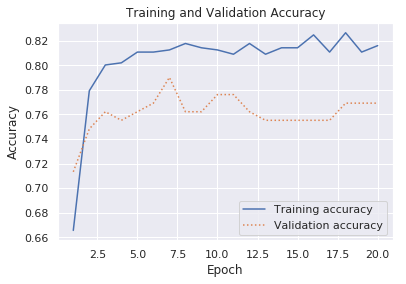

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

sns.set()
acc = hist.history['accuracy']
val = hist.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '-', label='Training accuracy')
plt.plot(epochs, val, ':', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.plot()

In [10]:
# Get the overall accuracy of the model
scores = model.evaluate(x_test, y_test, verbose=0) 
print("Accuracy: %.2f%%" % (scores[1] * 100))

Accuracy: 76.92%


Now let's the use the model to predict whether a 30-year-old female traveling in first class will survive the voyage.

In [11]:
import numpy as np

age = scaler.transform([[30]])[0][0]
input = np.array([[age, 1, 0, 1, 0, 0]])
probability = model.predict(input)[0][0]
print('Probability of survival: {:.1%}'.format(probability))

Probability of survival: 97.7%


How about a 60-year-old male in third class?

In [12]:
age = scaler.transform([[60]])[0][0]
input = np.array([[age, 0, 1, 0, 0, 1]])
probability = model.predict(input)[0][0]
print('Probability of survival: {:.1%}'.format(probability))

Probability of survival: 4.6%
